<header style="padding:10px;background:#f9f9f9;border-top:3px solid #00b2b1"><img id="Teradata-logo" src="https://www.teradata.com/Teradata/Images/Rebrand/Teradata_logo-two_color.png" alt="Teradata" width="220" align="right" />
 
## TF-IDF Workflow in SQL
</header>

**Notes**
* Teradata SQL User Guide: https://docs.teradata.com/r/Teradata-VantageTM-SQL-Fundamentals/July-2021
* Getting started with Teradata SQL extension for Jupyter: https://github.com/Teradata/jupyterextensions/blob/master/notebooks/sql/GettingStarted.ipynb
* Installing Teradata SQL extension for Jupyter:https://teradata.github.io/jupyterextensions/#/
* NGramSplitter Function Reference: https://docs.teradata.com/r/aKnWloeEx3pmus0aivWOaw/0uzj9gM6ureUUJTXhxvmSQ

**Steps**
1. Replace any hosts, schemas, usernames, etc.
2. Connect to existing data set containing fake product comments.
3. Use NGramSplitter SQL to create a table of grams of n-size.
4. Express SQL to calculate TF-IDF and store the output in a table.
5. Retrieve the data as a local dataframe.
6. Basic visualization to show top 30 important terms.

### Accessing the Data
<p style = 'font-size:16px;font-family:Arial'>These demos will work either with foreign tables accessed from Cloud Storage via NOS or you may import the tables to your machine. If you import data for multiple demos, you may need to use the Data Dictionary "Manage Your Space" routine to cleanup tables you no longer need. 
    
<p style = 'font-size:16px;font-family:Arial'>Use the link below to access the 2 options for using data from the data dictionary notebook:

[Click Here to get data for this notebook](../Data_Dictionary/Data_Dictionary.ipynb#TRNG_RETAILDSE)

[Click Here to Manage Your Space](../Data_Dictionary/Data_Dictionary.ipynb#Manage_Your_Space)

### Connect to Vantage ###
We can use the named connection using the connect magic as part of the Vantage Module for Jupyter.

In [2]:
%connect local

Password: ···


Success: 'local' connection established and activated for user 'demo_user'


### Access data in Vantage ###
For this demo, data is already resident in Vantage.  Create a reference to the table, and sample the contents.  Data could just as easily reside in Object Storage, another RDBMS, or another Vantage system.

In [3]:
sel top 5 * from TRNG_RETAILDSE.WEB_COMMENT

,comment_id,customer_id,comment_text,comment_summary
1,1672,1059,Can't go wrong with these new charlie's by cartonnier. they fit amazingly. the fabric is a textured cotton but doesn't seem to wrinkle. just shook them out of the bag yesterday. the fabric description says cotton and spandex so they have some give (just a little) but are not going to stretch out after wearing for an hour. paired it with all sorts of different tops. side zip is slimming. lined pockets. substantial fabric. nothing bad to say. if you haven't tried a pair of charlies you should. you,Another winner
2,12072,1033,,
3,12337,868,"I love the neckline on this - sharp enough for work, but cute for a fun night out too. only complaint is it's soooo flowy on the bottom. i could hide a baby under here for sure. i got the medium thank goodness or it would have been ridiculous. i'm 5'8, 160lbs. great for fall.",Loose and comfy
4,9992,1110,"So cute! i get tons of compliments whenever i wear it. very comfortable. i ordered a petite l and it's a little big. i usually buy the petite m, but due to the under slip i wasn't sure.",
5,7443,941,"I ordered my usual sz s during the promo. arrived yesterday & the fit is perfect w/ a little room to spare for layering. it's a snap front closure, front patch pockets, & attached hood that is small to med size-not huge or overwhelming. it's 100% acrylic which isn't my 1st choice, but soft, comfy & seems good quality. length falls abt 3"" below my knees. arm length is fine. pretty much looks as in the pic including the marled color. if you are in need of a great functional long swtr w/ good looks",A great long swtr w/ patch pockets!


### Use the NGram Splitter SQL Function ###
This function will split the corpus of documents into "terms" (grams) of selected size.  Specifically, this example will create a table called "tbl_grams" that is the result of splitting each "document" (review) into two-word chunks (grams).  Each row in this table includes;
1. The two-word chunk (ngram).
2. The source review id (row_id).
3. Chunk length (n).
4. The count of this chunk in the review (frequency).
5. The count of this chunk in all the reviews (totalcnt).

The splitting algorithm can be controlled with delimeters, punctuation indicators, etc.

In [3]:
DROP TABLE tbl_grams;

Success: 19 rows affected

In [4]:
%var ngram=2

In [5]:
CREATE TABLE tbl_grams AS (
    SELECT * FROM NGramSplitter ( 
        ON ( SELECT * FROM "TRNG_RETAILDSE"."WEB_COMMENT" )   
        USING 
            TextColumn('comment_text') 
            Accumulate('comment_id') 
            Grams('${ngram}') 
            OverLapping('TRUE') 
            ConvertToLowerCase('TRUE') 
            Delimiter(' ') 
            Punctuation('[`~#^&*()-]') 
            OutputTotalGramCount('TRUE') 
            NGramColName('ngram') 
            GramLengthColName('n') 
            FrequencyColName('frequency') 
            TotalCountColName('totalcnt') 
    ) as ngram_out
    )
WITH DATA
PRIMARY INDEX (comment_id);

Success: 0 rows affected

In [6]:
sel top 5 * from tbl_grams

,comment_id,ngram,n,frequency,totalcnt
1,0,and comfortable,2,1,6
2,0,and sexy,2,1,6
3,0,sexy and,2,1,6
4,0,wonderful silky,2,1,6
5,0,silky and,2,1,6


### Create the TF-IDF Table ###
TF-IDF or ***Term Frequency-Inverse Document Frequency*** is an indicator of a term's *importance* in a specific document based on the entire corpus of documents.  This value is calculated by taking the Product of:
* Term Frequency = (Number of Terms in the Document)/(Number of Terms in the Corpus)
* Inverse Document Frequency = Natural Log((Total Number of Documents)/(Number of Documents with the Term))

This can be accomplished in SQL using the results out the NGgram Splitter function:

In [7]:
DROP TABLE tbl_tf_idf;

ERROR: Unable to run SQL: Unable to run SQL query: Database reported error:3807:Object 'tbl_tf_idf' does not exist.

In [8]:
CREATE TABLE tbl_tf_idf AS (
SELECT gr.comment_id as comment_id,
gr."ngram" as term,
CAST (CAST(gr.frequency AS FLOAT) / CAST(gr.totalcnt AS FLOAT) AS DECIMAL(10,6)) as tf,
CAST(LN(sel_docs.tot_docs / sel_docs.tot_term) AS DECIMAL(10,6)) as idf,
CAST(idf * tf AS DECIMAL(10,6)) as tf_idf
FROM tbl_grams as gr
--get the number of docs where each term exists
LEFT JOIN (select "ngram", tot_term , tot_docs from
((SELECT "ngram",COUNT(*) as tot_term
FROM tbl_grams
GROUP BY "ngram") terms
--get the total doc count and join it to the table
CROSS JOIN (SELECT COUNT(DISTINCT comment_id) as tot_docs
FROM tbl_grams ) as sum_docs
)
) sel_docs
ON gr."ngram" = sel_docs."ngram"
WHERE tf_idf > .5
    )
WITH DATA
PRIMARY INDEX (comment_id);

Success: 0 rows affected

In [9]:
sel top 5 * from tbl_tf_idf

,comment_id,term,tf,idf,tf_idf
1,18169,is boxier,.062500,9.334326,.583395
2,18169,transparent fabric,.062500,10.027518,.626720
3,18169,recommend as,.062500,9.334326,.583395
4,18169,so open,.062500,8.928905,.558057
5,18169,slightly transparent,.062500,9.334326,.583395


### Visualize the Results ###
Builtin Teradata Jupyter modules can provide simple visualizations of the data:

In [10]:
sel top 30 term, tf_idf  from tbl_tf_idf order by tf_idf desc

,term,tf_idf
1,love embroidery,9.334326
2,great structure,9.334326
3,comfy cozy,8.418036
4,beautiful colors,6.470800
5,great style,6.470800
6,fits perfect,5.198497
7,fits perfect,5.198497
8,love birds,5.013759
9,weird liner,5.013759
10,great fit,4.934474


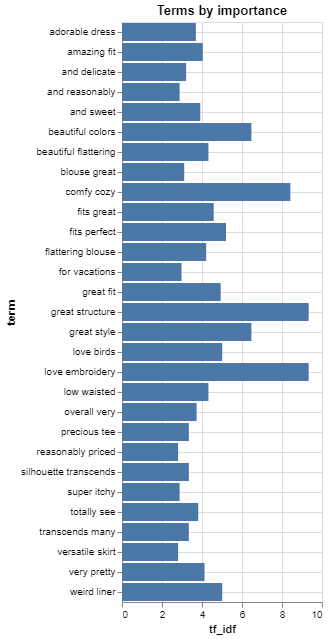

In [11]:
%chart x=tf_idf, y=term, title=Terms by importance

In [12]:
DROP TABLE tbl_grams;

Success: 19 rows affected

<footer style="padding:10px;background:#f9f9f9;border-bottom:3px solid #394851">©2022 Teradata. All Rights Reserved</footer>